In [139]:
import numpy as np
import matplotlib.pyplot as plt
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sys

if '/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages' not in sys.path:
    sys.path.append('/Users/svenkerstjens/DataSpell/lib/python3.9/site-packages')
import torch
from LIFlayer import NHiddenModel
from randman_data import get_data_loaders
from modularities_notebooks.modularity import clustered_connections, print_weight_matrix, compute_density_matrix, plot_connection_matrices
from sklearn.preprocessing import StandardScaler
import json
import tqdm.notebook as tqdm
from w import get_Ws
from init_utils import torch_init_LSUV


ImportError: cannot import name 'torch_init_LSUV' from 'init_utils' (/Users/kerstjens/msc_thesis/msc_thesis/init_utils.py)

In [14]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'device: {device}')
else:
    device = torch.device("cpu")
    print(f'device: {device}')


device: cuda


In [18]:
def train(dataloader_train,dataloader_test,model,decay,lr=1e-3,epochs=20,device=device, use_W=False,W=None):

    ce_loss = torch.nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    train_hist = []
    test_hist = []
    loss_hist = []
    pbar_epochs = tqdm.trange(epochs,leave=False,unit='epoch',position=0)

    if use_W:
        model.init_mod_weights(W)



    for e in pbar_epochs:
        losses = []
        acc_test = []
        acc_train = []


        #test loop
        for x,label in dataloader_test:
            Sprobe = torch.zeros((dataloader_test.batch_size,model.out_channels),device=device)
            x = x.float().to(device)
            label=label.reshape(dataloader_test.batch_size).to(device)
            model.init_states()
            with torch.no_grad():
                for t in range(x.shape[1]):
            

                    out_state = model(x[:,t])

                    Sprobe = decay * Sprobe + out_state.S
                prediction = Sprobe
                acc_test.append(np.mean((np.argmax(prediction.cpu(), axis=1)==label.cpu()).cpu().numpy()))

        #train loop
        for x,label in dataloader_train:
            Sprobe = torch.zeros((dataloader_train.batch_size,model.out_channels),device=device)
            x = x.float().to(device)
            label=label.reshape(dataloader_train.batch_size).to(device)
            model.init_states()
            for t in range(x.shape[1]):
            

                #out_state,spikes_per_layer = model(x[:,t])
                out_state = model(x[:,t])
                

                Sprobe = decay * Sprobe + out_state.S
#               spikes_per_layer = spikes_per_layer + spikes_per_layer
#                print(spikes_per_layer)
                
            prediction = Sprobe

            with torch.no_grad():
                acc_train.append(np.mean((np.argmax(prediction.cpu(), axis=1)==label.cpu()).numpy()))
            loss = ce_loss(prediction,label)
            losses.append(loss.detach().cpu().numpy())

            loss.backward()
            opt.step()
            opt.zero_grad()

            if use_W:
                model.init_mod_weights(W)
        #print(torch.sum(prediction,axis=1))
        pbar_epochs.set_description(" Loss {0:1.4} | Test Acc {1:2.2%}: | Train Acc {2:2.2%} " .format(np.mean(losses),np.mean(acc_test),np.mean(acc_train)))
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(acc_train))
        test_hist.append(np.mean(acc_test))
    return loss_hist,train_hist,test_hist

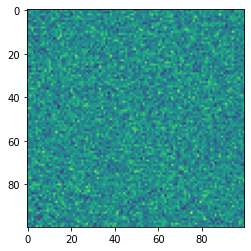

In [37]:
model = NHiddenModel(num_hidden_layers=1,in_channels=100,hidden_channels=100,out_channels=10,with_recurrent=False).to(device)
plt.imshow(model.layers[1].fc_layer.weight.data.cpu())

In [140]:

import datetime
import pickle


def run_experiment(variable,options,reps=reps, nb_classes=nb_classes,nb_units=nb_units,nb_steps=nb_steps,nb_samples=nb_samples,batchsize=batchsize,num_hidden_layers=num_hidden_layers,with_recurrent=with_recurrent,decay=decay,epochs=epochs,use_W=use_W,W=0,nb_blocks=nb_classes,epsilon=epsilon,modularity=modularity,lr=lr,print_weights=False,nametest=''):
    
    #init variable
   
    
    

    
    if variable != 'modularity':
        if use_W:
            W,W2=get_Ws(nb_units,nb_blocks,epsilon,modularity)

    metadata = locals()

    print(f'testing var -{variable}- with values -{options}-')
    dataloader_train,data_loader_test = get_data_loaders(nb_classes,nb_units,nb_steps,nb_samples,batchsize)
    experiment_data = {}
    
    for rep in range(reps):
        for i in range(len(options)):
        

        
            if variable == 'modularity':
                if use_W:
                    modularity = options[i]
                    W,W2=get_Ws(nb_units,nb_blocks,epsilon,modularity)

            if variable == 'num_hidden_layers':
                num_hidden_layers = options[i]

            if variable == 'lr':
                lr = options[i]
            
            
            model = NHiddenModel(num_hidden_layers=num_hidden_layers,in_channels=nb_units,hidden_channels=nb_units,out_channels=nb_classes,with_recurrent=with_recurrent).to(device)
            exploss,exptrain,exptest = train(dataloader_train,data_loader_test,model=model,decay=decay,epochs=epochs,use_W=use_W,W=W,lr=lr)

            experiment_data['loss_{}={}_rep{}'.format(variable,options[i],rep)] = exploss
            experiment_data['train_{}={}_rep{}'.format(variable,options[i],rep)] = exptrain
            experiment_data['test_{}={}_rep{}'.format(variable,options[i],rep)] = exptest
            
            #json_dict = json.dumps(experiment_data,indent=4)
            #meta_dict = json.dumps(metadata,indent=4)

            with open("experimental_data/{}{}.pkl".format(variable,nametest), 'wb') as f:
                pickle.dump(experiment_data, f)
            with open("experimental_data/{}{}_meta.pkl".format(variable,nametest), 'wb') as f:
                pickle.dump(metadata, f)
            #with open("\experimental_data\{}.json".format(variable),"w") as file:
            #    file.write(json_dict)
            #with open("\experimental_data\{}_meta.json".format(variable),"w") as file:
            #    file.write(meta_dict)

        if print_weights:
            plt.imshow(model.layers[1].fc_layer.weight.data.cpu())
            plt.colorbar()

    return experiment_data


    

testing var -modularity- with values -[0, 0.25, 0.5, 0.75, 1]-
device: cuda


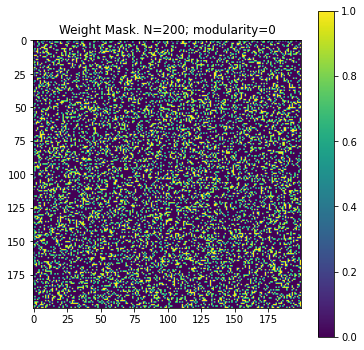

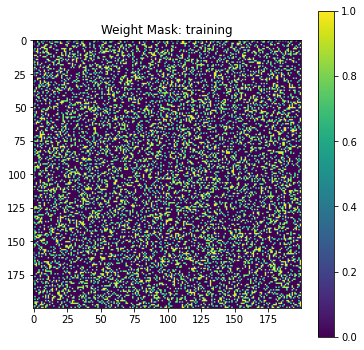

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


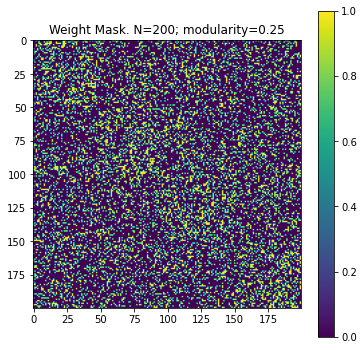

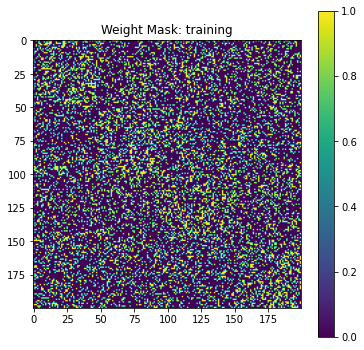

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


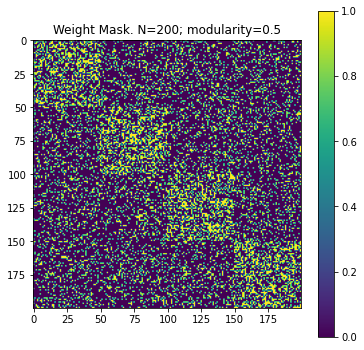

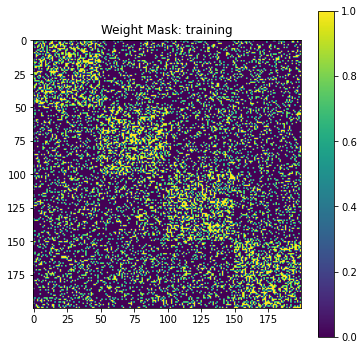

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


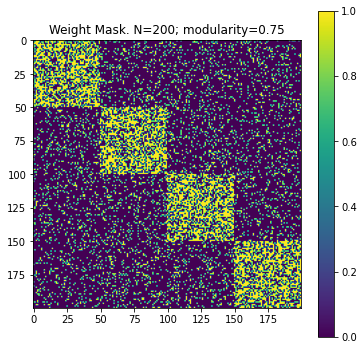

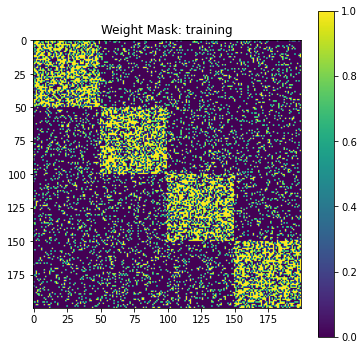

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


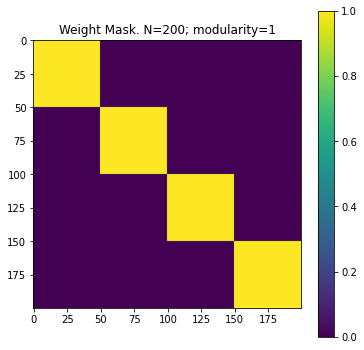

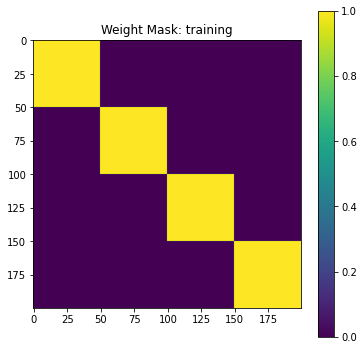

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


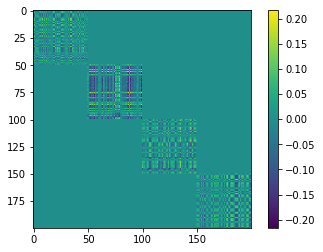

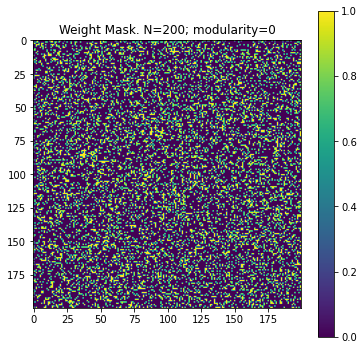

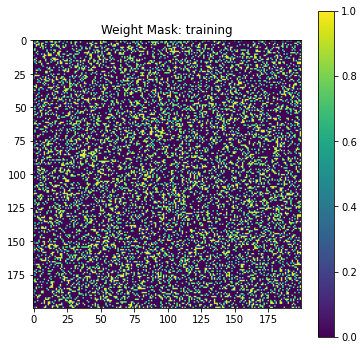

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


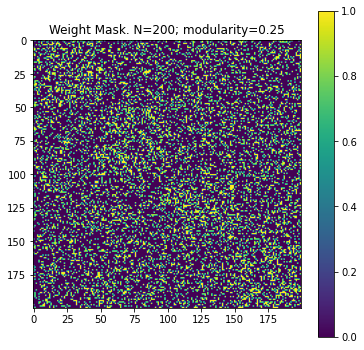

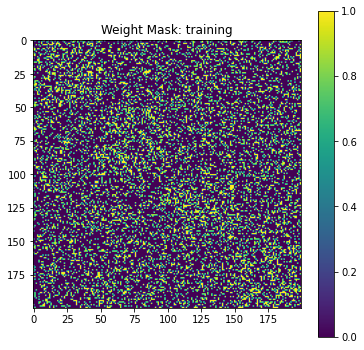

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


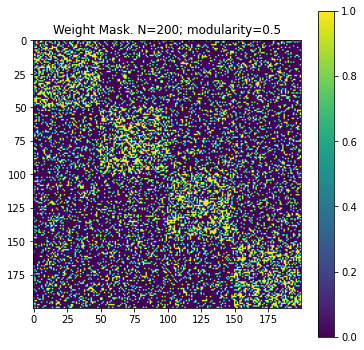

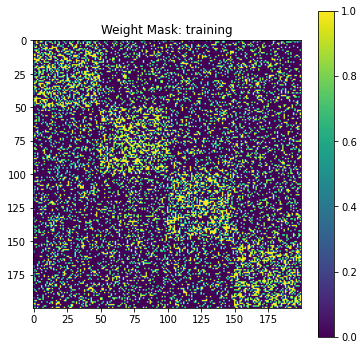

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


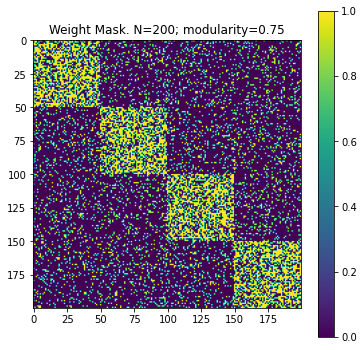

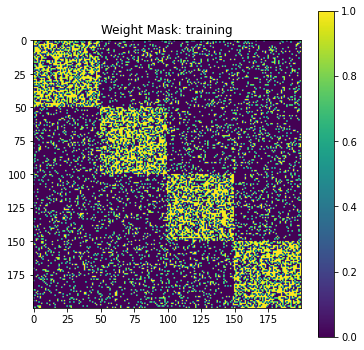

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


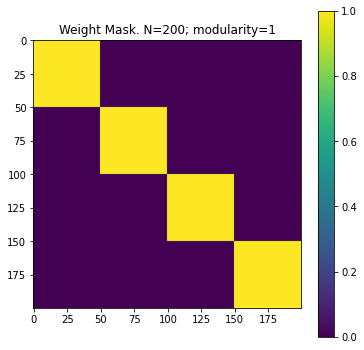

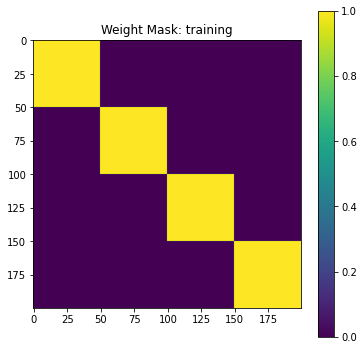

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


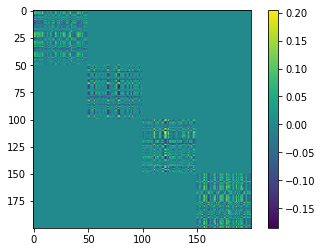

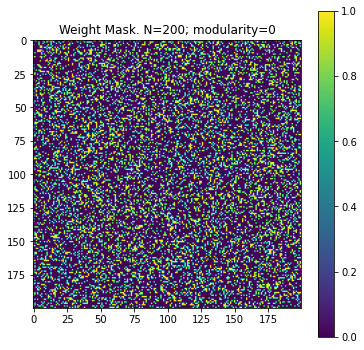

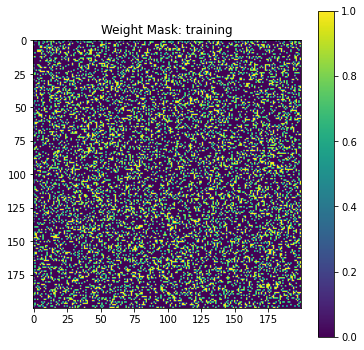

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


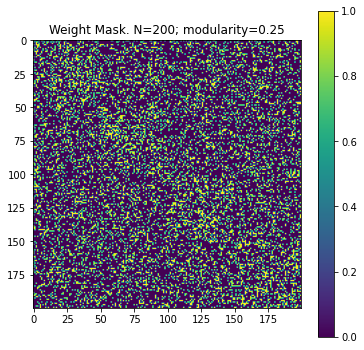

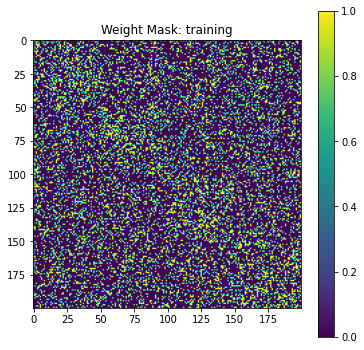

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


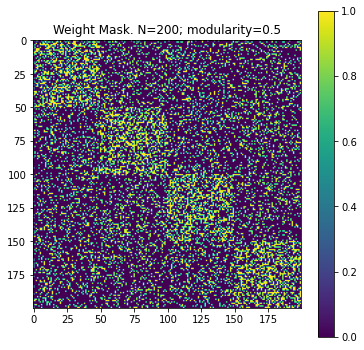

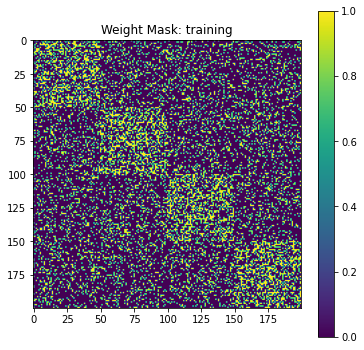

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


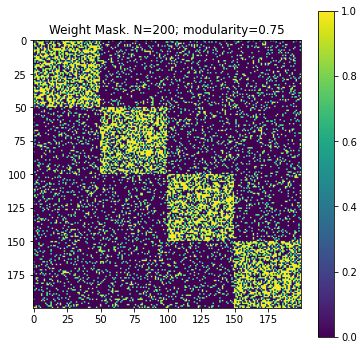

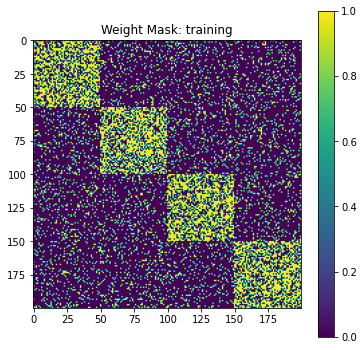

  0%|          | 0/20 [00:00<?, ?epoch/s]

device: cuda


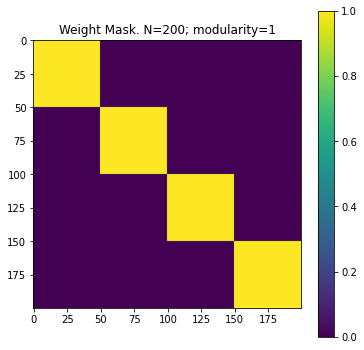

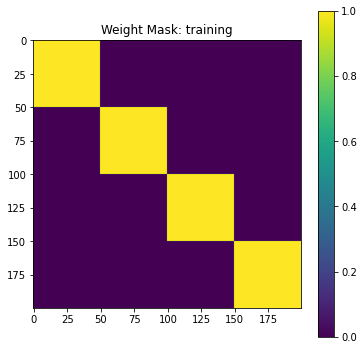

  0%|          | 0/20 [00:00<?, ?epoch/s]

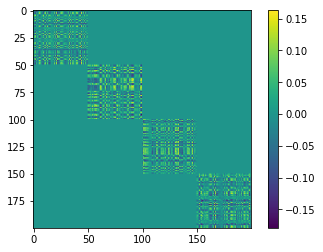

In [141]:
variable = 'modularity'
options = [0,1]
reps=3
nb_classes=4
nb_units = 200
nb_steps = 100
nb_samples = 400
batchsize = 100
num_hidden_layers = 7
with_recurrent=False
decay=.99
epochs=20
use_W=True
W=0
nb_blocks=nb_classes
epsilon=1
modularity=0
lr=1e-3
print_weights = True

exp = run_experiment(variable=variable,options=options,reps=reps, nb_classes=nb_classes,nb_units=nb_units,nb_steps=nb_steps,nb_samples=nb_samples,batchsize=batchsize,num_hidden_layers=num_hidden_layers,with_recurrent=with_recurrent,decay=decay,epochs=epochs,use_W=use_W,W=0,nb_blocks=nb_classes,epsilon=epsilon,modularity=modularity,lr=lr,print_weights=print_weights,nametest='10lay')

In [142]:
import pickle
with open('experimental_data/modularity7lay.pkl','rb') as f:
    mod_dict = pickle.load(f)

with open('experimental_data/modularity7lay_meta.pkl','rb') as f:
    modmeta_dict = pickle.load(f)

<AxesSubplot:>

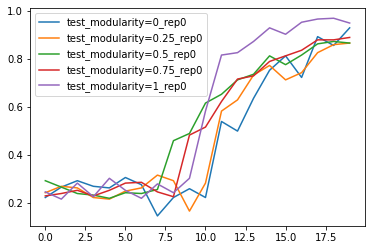

In [149]:
import pandas as pd
df = pd.DataFrame(mod_dict)
df[[col for col in list(mod_dict.keys()) if 'test' in col and 'rep0' in col]].plot(legend=True)

#plt.plot(df[[col for col in list(mod_dict.keys()) if 'test' in col and 'rep0' in col]])

In [132]:
df[[col for col in list(mod_dict.keys()) if 'test' in col and 'layers=8_' in col]].iloc[19]

test_num_hidden_layers=8_rep0    0.713333
test_num_hidden_layers=8_rep1    0.926667
test_num_hidden_layers=8_rep2    0.893333
test_num_hidden_layers=8_rep3    0.853333
test_num_hidden_layers=8_rep4    0.763333
test_num_hidden_layers=8_rep5    0.893333
test_num_hidden_layers=8_rep6    0.766667
test_num_hidden_layers=8_rep7    0.796667
test_num_hidden_layers=8_rep8    0.776667
test_num_hidden_layers=8_rep9    0.903333
Name: 19, dtype: float64

In [ ]:


from utils import forward_layer, torch_init_LSUV
data, target = next(iter(dataloader_train))
data_flat =  data.transpose(0,1).to(device).view(T,BATCHSIZE,-1)
torch_init_LSUV(net, data_flat, tgt_mu=-0.75) 

In [16]:
round(tic,)

1658137259

In [14]:
exp_data = run_experiment('num_hidden_layers',[0,1,2],epochs=5)

testing var -num_hidden_layers- with values -[0, 1, 2]-


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/5 [00:00<?, ?epoch/s]

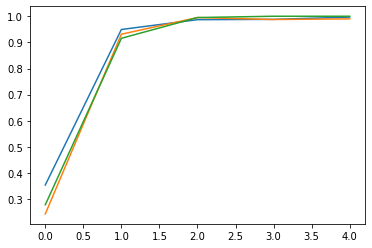

In [17]:
plt.plot(exp_data['train_num_hidden_layers=0'])
plt.plot(exp_data['train_num_hidden_layers=1'])
plt.plot(exp_data['train_num_hidden_layers=2'])

In [9]:
def check(a,b,c):
    args = locals()
    print(args)
    return args

args = check(3,'le',[3,4,5,6])

{'a': 3, 'b': 'le', 'c': [3, 4, 5, 6]}
